# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [1]:
import lightgbm, xgboost, category_encoders, sklearn
print("✅ Todo OK — librerías disponibles.")


✅ Todo OK — librerías disponibles.


In [2]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 130        # plts más nítidos
plt.rcParams["figure.autolayout"] = True
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    f1_score,accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, precision_recall_curve,
    ConfusionMatrixDisplay, confusion_matrix, classification_report
)


##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [3]:
results = pd.read_csv("./archive/results.csv", parse_dates=["date"])
#results["date"] = pd.to_datetime(results["date"], dayfirst=True, errors="coerce")
results["date"] = pd.to_datetime(results["date"], format="mixed", dayfirst=True, errors="coerce")

In [4]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [5]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


In [6]:
# OM: revisar estructura del dataset
results.info()
[results.head(5), results.tail(5)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        48532 non-null  datetime64[ns]
 1   home_team   48532 non-null  object        
 2   away_team   48532 non-null  object        
 3   home_score  48532 non-null  int64         
 4   away_score  48532 non-null  int64         
 5   tournament  48532 non-null  object        
 6   city        48532 non-null  object        
 7   country     48532 non-null  object        
 8   neutral     48532 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 3.0+ MB


[        date home_team away_team  home_score  away_score tournament     city  \
 0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
 1 1873-03-08   England  Scotland           4           2   Friendly   London   
 2 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
 3 1875-03-06   England  Scotland           2           2   Friendly   London   
 4 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   
 
     country  neutral  
 0  Scotland    False  
 1   England    False  
 2  Scotland    False  
 3   England    False  
 4  Scotland    False  ,
             date               home_team away_team  home_score  away_score  \
 48527 2025-09-09  Bosnia and Herzegovina   Austria           1           2   
 48528 2025-09-09                  Cyprus   Romania           2           2   
 48529 2025-09-09                  Norway   Moldova          11           1   
 48530 2025-09-09                 Albania    Latvia

In [7]:
# OM Cuántos torneos únicos hay en el dataset?
results["tournament"].nunique()

188

In [8]:
# OM ¿Cuál es la fecha del primer partido de copas del mundo  de la FIFA (1930 no tuvo clasificación para la Copa Mundial)?
results.loc[results["tournament"] == "FIFA World Cup", "date"].min()

Timestamp('1930-07-13 00:00:00')

In [9]:
# OM Filtrar el dataset para quedarnos solo con los partidos jugados desde la fecha del primer partido de copa del mundo de la FIFA en adelante. ¿Cuántos partidos hay en este subconjunto? 
results_filtrado = results[results["date"].dt.date >= pd.to_datetime(results.loc[results["tournament"] == "FIFA World Cup", "date"].min()).date()]
results_filtrado["tournament"].value_counts()

tournament
Friendly                                17276
FIFA World Cup qualification             8529
UEFA Euro qualification                  2824
African Cup of Nations qualification     2278
FIFA World Cup                            964
                                        ...  
TIFOCO Tournament                           1
Copa Confraternidad                         1
ConIFA Challenger Cup                       1
Benedikt Fontana Cup                        1
South Asian Super Cup                       1
Name: count, Length: 181, dtype: int64

In [10]:
# OM Cuántos torneos únicos hay en este subconjunto?
results_filtrado["tournament"].nunique()

181

In [11]:
# OM: A partir de aquí desarrollo el modelo predictivo

# Crear la columna target win/draw/loss basada en el resultado del partido
results_filtrado["goal_diff"] = results_filtrado["home_score"] - results_filtrado["away_score"]

# np.select por defecto usa 0 como default (entero), lo que genera conflicto de dtype con strings.
# Se especifica un default de tipo string para evitar el TypeError.
#results_filtrado["target"] = np.select(
#    [results_filtrado["goal_diff"] > 0, results_filtrado["goal_diff"] == 0, results_filtrado["goal_diff"] < 0],
#    ["win", "draw", "loss"],
#    default="unknown"
#)

results_filtrado = results_filtrado.copy()
sign_map = {1: "win", 0: "draw", -1: "loss"}
results_filtrado["target"] = np.sign(results_filtrado["goal_diff"]).map(sign_map)

# sanity check
assert results_filtrado["target"].isna().sum() == 0

Distribución del target:
target
win     0.489
loss    0.282
draw    0.229
Name: proportion, dtype: float64

Classification report (test):
              precision    recall  f1-score   support

        draw      0.265     0.135     0.179      2156
        loss      0.490     0.447     0.468      2651
         win      0.596     0.763     0.669      4603

    accuracy                          0.530      9410
   macro avg      0.450     0.448     0.438      9410
weighted avg      0.490     0.530     0.500      9410



<Figure size 585x520 with 0 Axes>

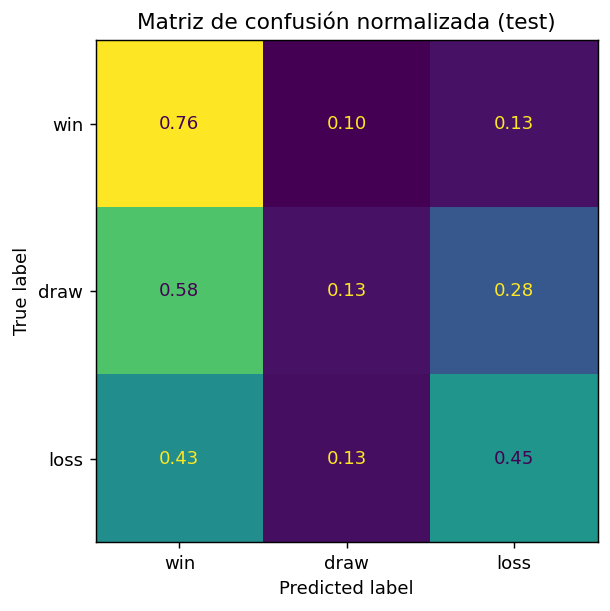


Top 12 importancias:
away_team     0.244065
home_team     0.229111
year          0.214052
month         0.116836
dayofweek     0.099395
tournament    0.085647
neutral       0.010894
dtype: float64


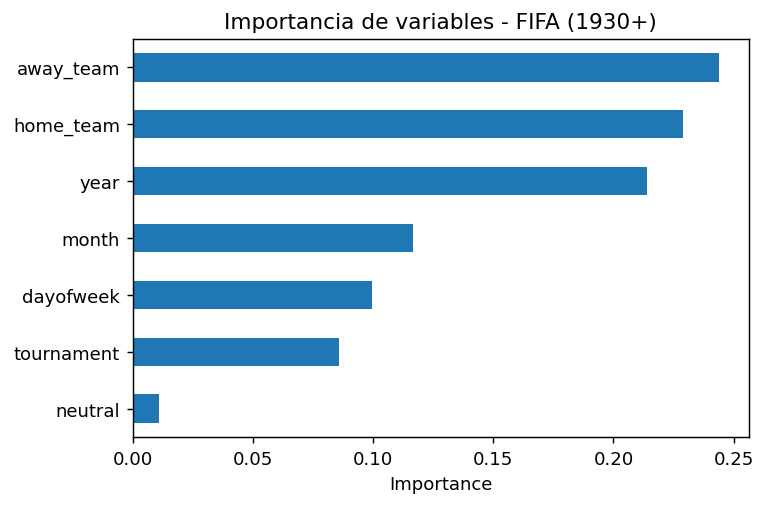

In [12]:
# Distribución (opcional)
print("Distribución del target:")
print(results_filtrado["target"].value_counts(normalize=True).round(3))

# =========================================
# 4) FEATURES base (roles explícitos + numéricas)
# =========================================
results_filtrado["year"] = results_filtrado["date"].dt.year
results_filtrado["month"] = results_filtrado["date"].dt.month
results_filtrado["dayofweek"] = results_filtrado["date"].dt.dayofweek
results_filtrado["neutral"] = results_filtrado["neutral"].astype(int)

feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek"]

X = results_filtrado[feat_cat + feat_num]
y = results_filtrado["target"]

# =========================================
# 5) SPLIT antes de cualquier fit (evita leakage)
# =========================================

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# =========================================
# 6) PREPROCESAMIENTO con ColumnTransformer
#    - TargetEncoder separado por columna (roles explícitos)
#    - Numéricas pasan "as is"
# =========================================

pre = ColumnTransformer(
    transformers=[
        # Cada TargetEncoder aprende su mapping usando SOLO el fold de train dentro del Pipeline
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    remainder="drop",
    verbose_feature_names_out=False  # nombres de salida más limpios
)

# =========================================
# 7) MODELO (baseline robusto)
# =========================================
clf = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"  # para que 'draw' no quede sub-representado
    ))
])

clf.fit(X_tr, y_tr)

# =========================================
# 8) EVALUACIÓN
# =========================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = clf.predict(X_te)

print("\nClassification report (test):")
print(classification_report(y_te, y_pred, digits=3))

cm = confusion_matrix(y_te, y_pred, labels=["win","draw","loss"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"])
plt.figure(figsize=(4.5,4))
disp.plot(values_format=".2f", cmap=None, colorbar=False)
plt.title("Matriz de confusión normalizada (test)")
plt.show()

# =========================================
# 9) IMPORTANCIA DE VARIABLES
#    Nota: tras el preprocesamiento, obtenemos los nombres de features
# =========================================
try:
    # Nombres de salida del ColumnTransformer
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    # Fallback si la versión no soporta get_feature_names_out()
    feature_names = np.array(
        ["home_team_TE", "away_team_TE", "tournament_TE"] + feat_num
    )

# Importancias desde el RandomForest dentro del Pipeline
rf = clf.named_steps["rf"]
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nTop 12 importancias:")
print(importances.head(12))

plt.figure(figsize=(6,4))
importances.head(12).sort_values().plot(kind="barh")
plt.title("Importancia de variables - FIFA (1930+)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [13]:
# OM: Vamos a comparar contra los resultados originales del dataset (Predicción Vs. Realidad)

# --- Comparación fila a fila real vs predicho ---
comparacion = X_te.copy()
comparacion["real"] = y_te.values
comparacion["predicho"] = y_pred
comparacion["ok"] = comparacion["real"] == comparacion["predicho"]

# Proporción de aciertos
print("\nProporción de aciertos global:")
print(comparacion["ok"].value_counts(normalize=True))

# Ejemplo de visualización
print("\nAlgunas predicciones vs realidad:")
print(comparacion.sample(10))


Proporción de aciertos global:
ok
True     0.530074
False    0.469926
Name: proportion, dtype: float64

Algunas predicciones vs realidad:
         home_team    away_team                            tournament  \
34665       Greece       Poland                              Friendly   
21640       Israel       Greece                              Friendly   
9752       Tunisia         Iraq                              Friendly   
13301     Scotland  New Zealand                        FIFA World Cup   
3391         Italy       Sweden                        FIFA World Cup   
22650        Aruba      Curaçao       CFU Caribbean Cup qualification   
32438  Netherlands      Iceland          FIFA World Cup qualification   
8906      Paraguay   Yugoslavia               Brazil Independence Cup   
17898        Chile    Argentina                          Copa América   
34201        Ghana        Sudan  African Cup of Nations qualification   

       neutral  year  month  dayofweek  real predicho    

In [14]:
# OM: Incorporamos un ranking de desempeño de los equipos basado en los últimos 20 partidos o 2 años jugados

from collections import deque
from math import log

# ====== Parámetros ======
R0 = 1500.0
K_base = 20.0
HOME_ADV = 80.0           # ventaja local en puntos ELO
half_life_years = 2.0     # half-life (2 o 3 años suelen andar muy bien)
half_life_days  = 365.0 * half_life_years
N_prev = 20               # ← cantidad de partidos “hacia atrás” por equipo

# Pesos por torneo (ajustables). Default = 1.1 como pediste.
weights = {
    "FIFA World Cup": 1.6,
    "UEFA European Championship": 1.4,
    "Copa América": 1.4,
    "FIFA World Cup qualification": 1.3,
    "UEFA Nations League": 1.2,
    "Friendly": 0.9,
}
def w_tournament(t):
    return weights.get(t, 1.1)  # ← default sensato

def elo_expect(Ra, Rb, home_adv):
    return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

# ====== Estado del ranking ======
ratings = {}             # rating actual por team
last_played = {}         # última fecha jugada por team
recent_counts = {}       # deque de fechas recientes por team (para contar <= N_prev rápido)

snapshots = []

df = results_filtrado.sort_values("date").copy()  # aseguramos orden temporal

for _, row in df.iterrows():
    d   = row["date"]
    ht  = row["home_team"]; at  = row["away_team"]
    hs  = row["home_score"]; as_ = row["away_score"]
    tour = row["tournament"]; neut = bool(row["neutral"])

    # init estructuras si no existen
    if ht not in ratings: ratings[ht] = R0
    if at not in ratings: ratings[at] = R0
    if ht not in recent_counts: recent_counts[ht] = deque(maxlen=N_prev)
    if at not in recent_counts: recent_counts[at] = deque(maxlen=N_prev)

    # --- Decaimiento temporal hacia R0 si pasó tiempo sin jugar ---
    for team in (ht, at):
        if team in last_played:
            delta_days = (d - last_played[team]).days
            if delta_days > 0:
                decay = 0.5 ** (delta_days / half_life_days)
                ratings[team] = R0 + (ratings[team] - R0) * decay

    Rh, Ra = ratings[ht], ratings[at]

    # --- Probabilidades esperadas con ventaja local (si no es neutral) ---
    home_adv = 0.0 if neut else HOME_ADV
    Eh = elo_expect(Rh, Ra, home_adv)
    Ea = 1.0 - Eh

    # --- Resultado real (POV local) ---
    if   hs > as_: Sh, Sa = 1.0, 0.0
    elif hs < as_: Sh, Sa = 0.0, 1.0
    else:          Sh, Sa = 0.5, 0.5

    # --- Margen de victoria suavizado (opcional) ---
    margin = max(1.0, log(1 + abs(hs - as_), 2))  # log base 2

    # --- K dinámico por torneo + margen ---
    Kw_base = K_base * w_tournament(tour) * margin

    # --- Factor por cantidad de partidos recientes (N_prev) ---
    #   Si un equipo tiene menos de N_prev previos, reducimos su K para no sobre-reaccionar.
    cnt_h = len(recent_counts[ht])
    cnt_a = len(recent_counts[at])
    factor_h = min(1.0, cnt_h / N_prev)
    factor_a = min(1.0, cnt_a / N_prev)

    Kw_h = Kw_base * (0.5 + 0.5 * factor_h)  # nunca cero: mínimo 0.5x para que igual aprenda
    Kw_a = Kw_base * (0.5 + 0.5 * factor_a)

    # --- Actualización ELO por lado ---
    ratings[ht] = Rh + Kw_h * (Sh - Eh)
    ratings[at] = Ra + Kw_a * (Sa - Ea)

    # --- Actualizamos contadores y última fecha ---
    recent_counts[ht].append(d)
    recent_counts[at].append(d)
    last_played[ht] = d
    last_played[at] = d

    # --- Guardamos snapshot para merge posterior ---
    snapshots.append({
        "date": d,
        "home_team": ht, "away_team": at,
        "home_rating": ratings[ht],
        "away_rating": ratings[at]
    })

ratings_df = pd.DataFrame(snapshots).sort_values("date").reset_index(drop=True)

# Merge al dataset y feature final
results_with_rating = df.merge(
    ratings_df, on=["date","home_team","away_team"], how="left"
)
results_with_rating["rating_diff"] = results_with_rating["home_rating"] - results_with_rating["away_rating"]



Classification report con rating_diff:
              precision    recall  f1-score   support

        draw      0.371     0.159     0.223      2156
        loss      0.627     0.686     0.655      2651
         win      0.697     0.846     0.764      4604

    accuracy                          0.643      9411
   macro avg      0.565     0.564     0.547      9411
weighted avg      0.603     0.643     0.609      9411



<Figure size 585x520 with 0 Axes>

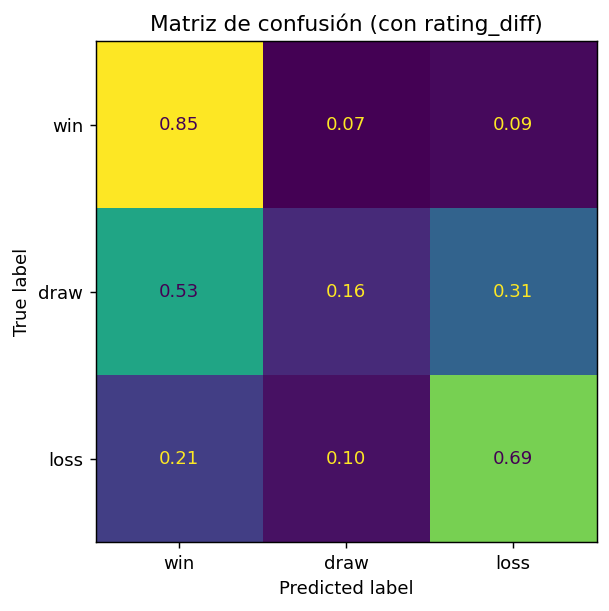


Top 10 importancias:
rating_diff    0.343256
away_team      0.153122
home_team      0.143469
year           0.134812
month          0.082650
tournament     0.066367
dayofweek      0.065721
neutral        0.010604
dtype: float64


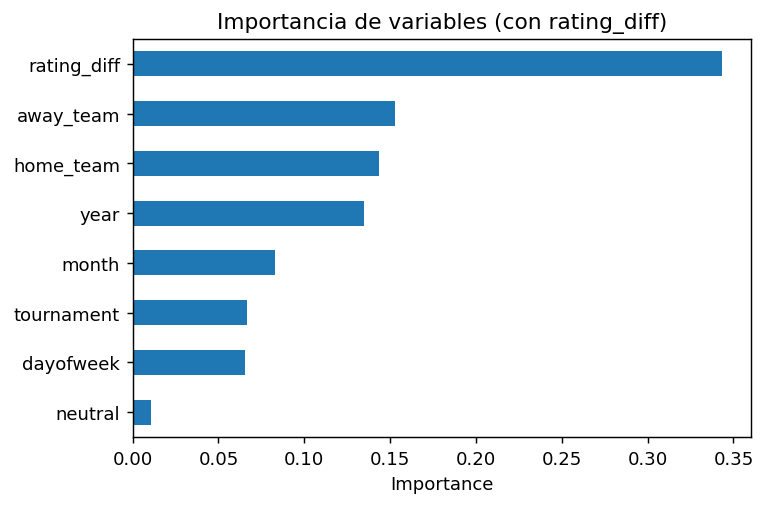

In [15]:
# OM: modelamos de nuevo con la feature adicional de rating_diff

# --- Features ---
feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek", "rating_diff"]

X = results_with_rating[feat_cat + feat_num]
y = results_with_rating["target"]

# --- Split ---
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# --- Preprocesamiento + Modelo ---
pre = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# --- Fit ---
clf.fit(X_tr, y_tr)

# --- Predicciones ---
y_pred = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)

# --- Reporte ---
print("\nClassification report con rating_diff:")
print(classification_report(y_te, y_pred, digits=3))

# --- Matriz de confusión normalizada ---
cm = confusion_matrix(y_te, y_pred, labels=["win","draw","loss"], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"])
plt.figure(figsize=(4.5,4))
disp.plot(values_format=".2f", cmap=None, colorbar=False)
plt.title("Matriz de confusión (con rating_diff)")
plt.show()

# --- Importancia de features ---
try:
    feature_names = clf.named_steps["pre"].get_feature_names_out()
except Exception:
    feature_names = np.array(["home_team_TE","away_team_TE","tournament_TE"] + feat_num)

importances = pd.Series(clf.named_steps["rf"].feature_importances_, index=feature_names).sort_values(ascending=False)

print("\nTop 10 importancias:")
print(importances.head(10))

plt.figure(figsize=(6,4))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Importancia de variables (con rating_diff)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [16]:
# Comparamos métricas de acierto global

comparacion = X_te.copy()
comparacion["real"] = y_te.values
comparacion["predicho"] = y_pred
comparacion["ok"] = comparacion["real"] == comparacion["predicho"]

print("\nProporción de aciertos global (modelo con rating_diff):")
print(comparacion["ok"].value_counts(normalize=True))



Proporción de aciertos global (modelo con rating_diff):
ok
True     0.643396
False    0.356604
Name: proportion, dtype: float64


In [17]:
# Cómo resulta versus la predicción anterior antes de correr el nuevo modelo:
# y_pred_old = clf_sin_rating.predict(X_te_old)

# ---- 0) Alinear filas entre datasets (evitamos NaN en rating_diff)
base_df   = results_filtrado.copy()
plus_df   = results_with_rating.copy()  # tiene home_rating, away_rating, rating_diff

# ============================================
# 0) Alineación robusta por claves (merge)
# ============================================

# Asegúrate de que results_filtrado ya tenga estas columnas temporales creadas.
if not {"year","month","dayofweek"}.issubset(results_filtrado.columns):
    tmp = results_filtrado.copy()
    tmp["year"] = tmp["date"].dt.year
    tmp["month"] = tmp["date"].dt.month
    tmp["dayofweek"] = tmp["date"].dt.dayofweek
else:
    tmp = results_filtrado.copy()

# Hacemos merge para traer ratings al dataset base por claves únicas del partido
merged = tmp.merge(
    results_with_rating[["date","home_team","away_team","home_rating","away_rating","rating_diff"]],
    on=["date","home_team","away_team"],
    how="left"
)

# Filtramos SOLO partidos con rating_diff disponible (por si algo quedó sin calcular)
merged = merged.loc[merged["rating_diff"].notna()].reset_index(drop=True)

# Creamos versiones "base" (sin rating_diff) y "plus" (con rating_diff), YA ALINEADAS
base_df = merged.drop(columns=["home_rating","away_rating","rating_diff"], errors="ignore").copy()
plus_df = merged.copy()

# (si aún no tenés el 'target' en merged, créalo aquí)
if "target" not in base_df.columns:
    base_df["goal_diff"] = base_df["home_score"] - base_df["away_score"]
    sign_map = {1: "win", 0: "draw", -1: "loss"}
    base_df["target"] = np.sign(base_df["goal_diff"]).map(sign_map)

if "target" not in plus_df.columns:
    plus_df["goal_diff"] = plus_df["home_score"] - plus_df["away_score"]
    sign_map = {1: "win", 0: "draw", -1: "loss"}
    plus_df["target"] = np.sign(plus_df["goal_diff"]).map(sign_map)

# ---- 1) Definir features y target para ambos
feat_cat = ["home_team", "away_team", "tournament"]
feat_num_base = ["neutral","year","month","dayofweek"]
feat_num_plus = feat_num_base + ["rating_diff"]

X_base = base_df[feat_cat + feat_num_base]
X_plus = plus_df[feat_cat + feat_num_plus]
y      = base_df["target"]  # mismo target para ambos

# ---- 2) Un solo split de ÍNDICES y se reutiliza en ambos modelos
idx = np.arange(len(y))
idx_tr, idx_te = train_test_split(idx, test_size=0.20, random_state=42, stratify=y)

Xb_tr, Xb_te = X_base.iloc[idx_tr], X_base.iloc[idx_te]
Xp_tr, Xp_te = X_plus.iloc[idx_tr], X_plus.iloc[idx_te]
y_tr,  y_te  = y.iloc[idx_tr],      y.iloc[idx_te]

# ---- 3) Preprocesamiento (TargetEncoder por rol) y modelos
pre_base = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num_base),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

pre_plus = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num_plus),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

clf_old = Pipeline([
    ("pre", pre_base),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"))
])
clf_new = Pipeline([
    ("pre", pre_plus),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"))
])

# ---- 4) Entrenar ambos y guardar predicciones
clf_old.fit(Xb_tr, y_tr)
y_pred_old = clf_old.predict(Xb_te)

clf_new.fit(Xp_tr, y_tr)
y_pred_new = clf_new.predict(Xp_te)

print("\n== Reporte MODELO VIEJO (sin rating_diff) ==")
print(classification_report(y_te, y_pred_old, digits=3))

print("\n== Reporte MODELO NUEVO (con rating_diff) ==")
print(classification_report(y_te, y_pred_new, digits=3))

# ---- 5) Comparación fila a fila (lado a lado)
comparacion = Xp_te.copy()  # cualquiera de los dos X_te sirve; tienen los mismos idx
comparacion["real"]         = y_te.values
comparacion["predicho_old"] = y_pred_old
comparacion["predicho_new"] = y_pred_new
comparacion["mejoró"]  = (comparacion["predicho_new"] == comparacion["real"]) & (comparacion["predicho_old"] != comparacion["real"])
comparacion["empeoró"] = (comparacion["predicho_new"] != comparacion["real"]) & (comparacion["predicho_old"] == comparacion["real"])

print("\nResumen comparativo:")
print("Accuracy viejo:", (comparacion["predicho_old"] == comparacion["real"]).mean())
print("Accuracy nuevo:", (comparacion["predicho_new"] == comparacion["real"]).mean())
print("Partidos que MEJORÓ:", comparacion["mejoró"].sum())
print("Partidos que EMPEORÓ:", comparacion["empeoró"].sum())


== Reporte MODELO VIEJO (sin rating_diff) ==
              precision    recall  f1-score   support

        draw      0.265     0.133     0.177      2157
        loss      0.493     0.448     0.469      2652
         win      0.594     0.765     0.669      4604

    accuracy                          0.531      9413
   macro avg      0.451     0.448     0.438      9413
weighted avg      0.490     0.531     0.500      9413


== Reporte MODELO NUEVO (con rating_diff) ==
              precision    recall  f1-score   support

        draw      0.328     0.142     0.199      2157
        loss      0.627     0.686     0.655      2652
         win      0.691     0.837     0.757      4604

    accuracy                          0.635      9413
   macro avg      0.549     0.555     0.537      9413
weighted avg      0.590     0.635     0.600      9413


Resumen comparativo:
Accuracy viejo: 0.5305428662488049
Accuracy nuevo: 0.6352916179751408
Partidos que MEJORÓ: 1607
Partidos que EMPEORÓ: 621



Resumen comparativo de métricas:


,Clase,Precision_old,Recall_old,F1_old,Precision_new,Recall_new,F1_new
0,win,0.594,0.765,0.669,0.691,0.837,0.757
1,draw,0.265,0.133,0.177,0.328,0.142,0.199
2,loss,0.493,0.448,0.469,0.627,0.686,0.655
3,Global,0.531,0.531,0.531,0.635,0.635,0.635


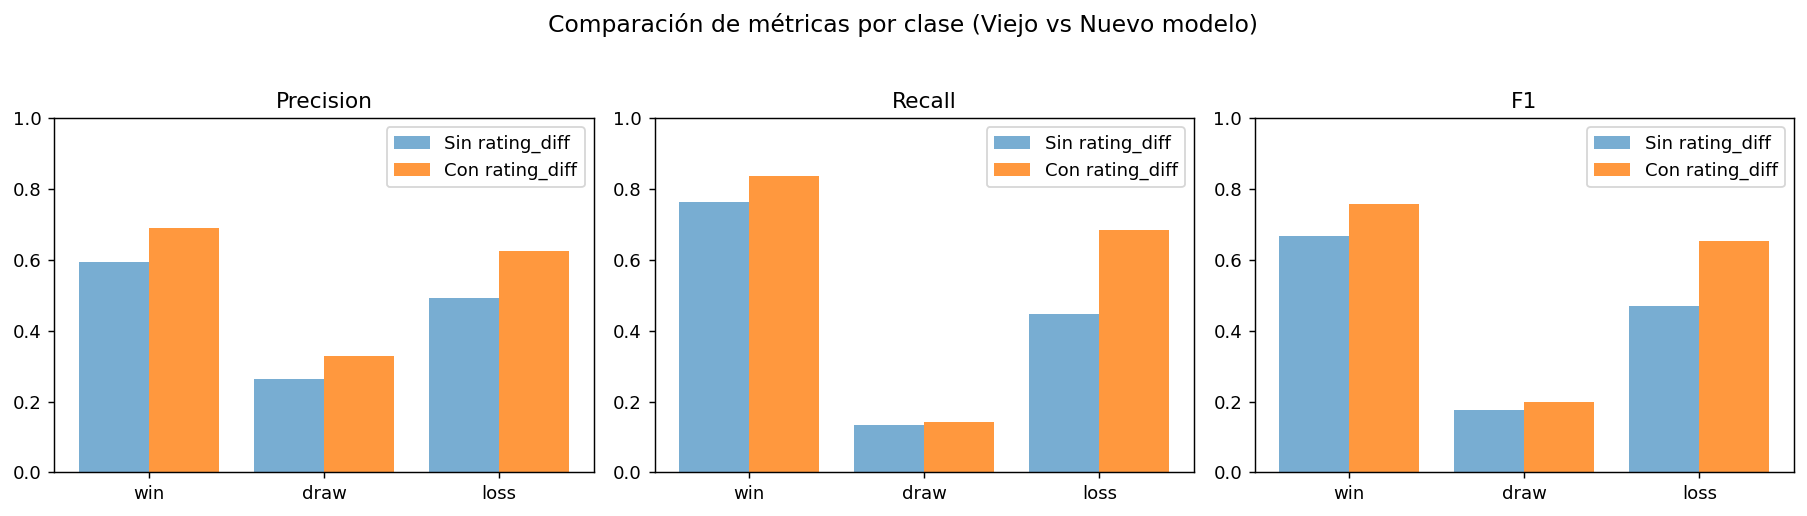

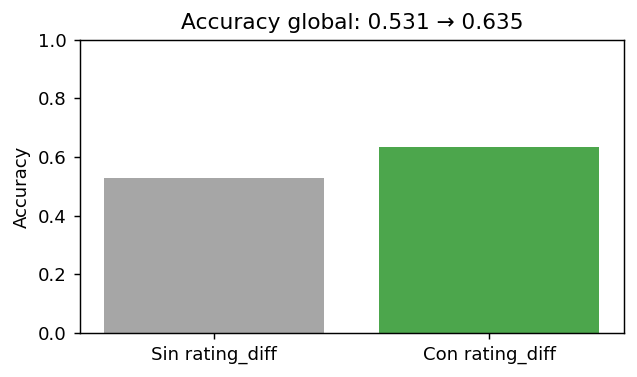

In [18]:
# ============================================================
# 6) Comparación visual: performance viejo vs nuevo
# ============================================================

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# --- Métricas por clase ---
labels = ["win", "draw", "loss"]

prec_old, rec_old, f1_old, _ = precision_recall_fscore_support(y_te, y_pred_old, labels=labels, zero_division=0)
prec_new, rec_new, f1_new, _ = precision_recall_fscore_support(y_te, y_pred_new, labels=labels, zero_division=0)

acc_old = accuracy_score(y_te, y_pred_old)
acc_new = accuracy_score(y_te, y_pred_new)

# --- DataFrame resumen ---
df_metrics = pd.DataFrame({
    "Clase": labels + ["Global"],
    "Precision_old": list(prec_old) + [np.nan],
    "Recall_old": list(rec_old) + [np.nan],
    "F1_old": list(f1_old) + [np.nan],
    "Precision_new": list(prec_new) + [np.nan],
    "Recall_new": list(rec_new) + [np.nan],
    "F1_new": list(f1_new) + [np.nan],
})
df_metrics.loc[df_metrics["Clase"]=="Global", ["Precision_old","Recall_old","F1_old"]] = acc_old
df_metrics.loc[df_metrics["Clase"]=="Global", ["Precision_new","Recall_new","F1_new"]] = acc_new

print("\nResumen comparativo de métricas:")
display(df_metrics.round(3))

# --- Visualización ---
fig, axes = plt.subplots(1, 3, figsize=(14,4))
metricas = ["Precision", "Recall", "F1"]

for i, met in enumerate(metricas):
    axes[i].bar(np.arange(len(labels)), df_metrics[f"{met}_old"][:-1], width=0.4, label="Sin rating_diff", alpha=0.6)
    axes[i].bar(np.arange(len(labels))+0.4, df_metrics[f"{met}_new"][:-1], width=0.4, label="Con rating_diff", alpha=0.8)
    axes[i].set_xticks(np.arange(len(labels))+0.2)
    axes[i].set_xticklabels(labels)
    axes[i].set_title(met)
    axes[i].set_ylim(0,1)
    axes[i].legend()

plt.suptitle("Comparación de métricas por clase (Viejo vs Nuevo modelo)", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Global accuracy barplot ---
plt.figure(figsize=(5,3))
plt.bar(["Sin rating_diff","Con rating_diff"], [acc_old, acc_new], color=["gray","green"], alpha=0.7)
plt.title(f"Accuracy global: {acc_old:.3f} → {acc_new:.3f}")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()



== Reporte con regla de empate (thr=0.45) ==
              precision    recall  f1-score   support

        draw      0.339     0.300     0.319      2157
        loss      0.674     0.618     0.645      2652
         win      0.723     0.796     0.757      4604

    accuracy                          0.632      9413
   macro avg      0.579     0.571     0.574      9413
weighted avg      0.621     0.632     0.625      9413



<Figure size 585x520 with 0 Axes>

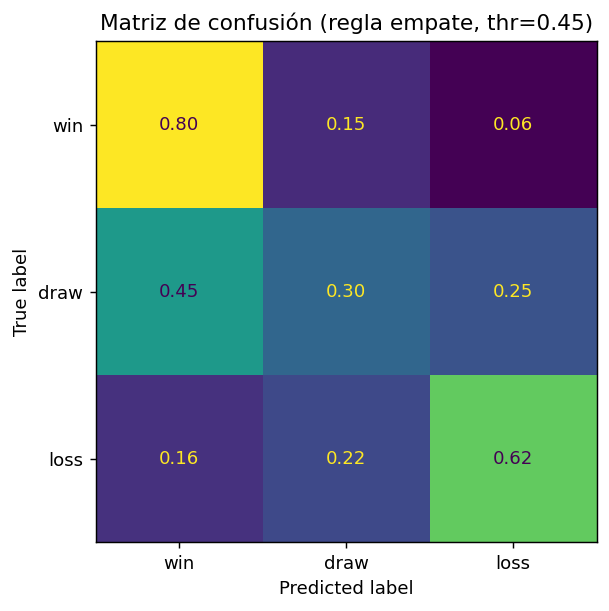


Sensibilidad por umbral (ordenado por macro_f1):
    thr  accuracy  macro_f1  recall_win  recall_draw  recall_loss  f1_win  \
2  0.50     0.617     0.577       0.749        0.412        0.554   0.746   
1  0.45     0.632     0.574       0.796        0.300        0.618   0.757   
3  0.55     0.597     0.571       0.697        0.519        0.487   0.730   
0  0.40     0.639     0.559       0.823        0.208        0.669   0.759   

   f1_draw  f1_loss  
2    0.367    0.618  
1    0.319    0.645  
3    0.398    0.587  
0    0.260    0.659  


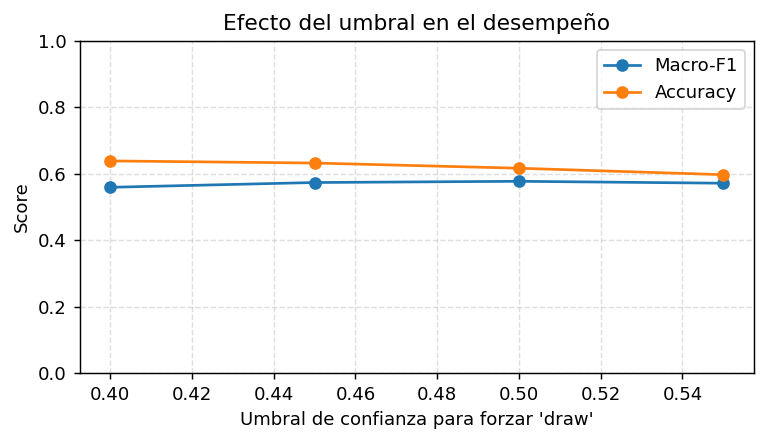

In [19]:
# OM: Empate por baja confianza + evaluación
# (usar después de entrenar clf_new)
# ============================================

# Probabilidades del modelo nuevo
proba = clf_new.predict_proba(Xp_te)
classes = clf_new.classes_

# Función que aplica la regla: si max(p) < thr => "draw", si no => clase argmax
def predict_with_draw_rule(proba, classes, thr=0.45):
    maxp = proba.max(axis=1)
    argmax_idx = proba.argmax(axis=1)
    pred = classes[argmax_idx].astype(object)

    # forzamos "draw" cuando no hay confianza alta en ninguna clase
    pred[maxp < thr] = "draw"
    return pred

# ---------- 1) Evaluación con un umbral base (0.45) ----------
thr = 0.45
y_pred_adj = predict_with_draw_rule(proba, classes, thr)

print(f"\n== Reporte con regla de empate (thr={thr:.2f}) ==")
print(classification_report(y_te, y_pred_adj, digits=3))

cm = confusion_matrix(y_te, y_pred_adj, labels=["win","draw","loss"], normalize="true")
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(4.5,4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win","draw","loss"]).plot(values_format=".2f", colorbar=False)
plt.title(f"Matriz de confusión (regla empate, thr={thr:.2f})")
plt.show()

# ---------- 2) Sensibilidad del umbral ----------
thresholds = [0.40, 0.45, 0.50, 0.55]
rows = []
for t in thresholds:
    y_adj = predict_with_draw_rule(proba, classes, t)
    acc = accuracy_score(y_te, y_adj)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_adj, labels=["win","draw","loss"], zero_division=0)
    macro_f1 = f1.mean()
    rows.append({
        "thr": t,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "recall_win": rec[0],
        "recall_draw": rec[1],
        "recall_loss": rec[2],
        "f1_win": f1[0],
        "f1_draw": f1[1],
        "f1_loss": f1[2],
    })

sens = pd.DataFrame(rows)
print("\nSensibilidad por umbral (ordenado por macro_f1):")
print(sens.sort_values("macro_f1", ascending=False).round(3))

# ---------- 3) Gráfico rápido (macro-F1 y accuracy vs umbral) ----------
plt.figure(figsize=(6,3.5))
plt.plot(sens["thr"], sens["macro_f1"], marker="o", label="Macro-F1")
plt.plot(sens["thr"], sens["accuracy"], marker="o", label="Accuracy")
plt.xlabel("Umbral de confianza para forzar 'draw'")
plt.ylabel("Score")
plt.title("Efecto del umbral en el desempeño")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [20]:
# Probabilidades:
proba = clf_new.predict_proba(Xp_te)
classes = clf_new.classes_
ix_win  = np.where(classes=="win")[0][0]
ix_draw = np.where(classes=="draw")[0][0]
ix_loss = np.where(classes=="loss")[0][0]

def predict_with_draw_rule_2d(proba, classes, thr=0.50, gap=0.10):
    pmax = proba.max(axis=1)
    pw, pd, pl = proba[:, ix_win], proba[:, ix_draw], proba[:, ix_loss]
    pred_idx = proba.argmax(axis=1)
    pred = classes[pred_idx].astype(object)
    # condición doble: poca confianza + p_win y p_loss muy cercanas
    mask_draw = (pmax < thr) & (np.abs(pw - pl) < gap)
    pred[mask_draw] = "draw"
    return pred


In [21]:
# ---------- 4) Sensibilidad doble (thr + gap) ----------
rows = []
for thr in [0.45, 0.50, 0.55]:
    for gap in [0.08, 0.10, 0.12, 0.15]:
        y_adj = predict_with_draw_rule_2d(proba, classes, thr=thr, gap=gap)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_te, y_adj, labels=["win","draw","loss"], zero_division=0
        )
        rows.append({
            "thr": thr, "gap": gap,
            "accuracy": accuracy_score(y_te, y_adj),
            "macro_f1": f1.mean(),
            "recall_win": rec[0], "recall_draw": rec[1], "recall_loss": rec[2]
        })
sens2 = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
print(sens2.head(10).round(3))


     thr   gap  accuracy  macro_f1  recall_win  recall_draw  recall_loss
3   0.45  0.15     0.635     0.565       0.813        0.247        0.643
11  0.55  0.15     0.633     0.565       0.809        0.258        0.630
7   0.50  0.15     0.633     0.565       0.810        0.257        0.631
6   0.50  0.12     0.637     0.564       0.818        0.235        0.650
10  0.55  0.12     0.637     0.564       0.818        0.235        0.650
2   0.45  0.12     0.638     0.564       0.819        0.229        0.657
5   0.50  0.10     0.639     0.562       0.823        0.220        0.659
9   0.55  0.10     0.639     0.562       0.823        0.220        0.659
1   0.45  0.10     0.639     0.561       0.824        0.216        0.663
4   0.50  0.08     0.638     0.557       0.826        0.204        0.666


In [22]:
# OM: Extra: incorporar rating_diff en la regla (3D)
# ============================================

rd = Xp_te["rating_diff"].values  # diferencia de rating del set de test

def predict_with_draw_rule_3d(proba, classes, thr=0.45, gap=0.10, rd_max=60):
    ix_win  = np.where(classes == "win")[0][0]
    ix_loss = np.where(classes == "loss")[0][0]
    pmax = proba.max(axis=1)
    pw, pl = proba[:, ix_win], proba[:, ix_loss]
    pred_idx = proba.argmax(axis=1)
    pred = classes[pred_idx].astype(object)
    # condición triple: baja confianza + equilibrio + partido parejo
    mask_draw = (pmax < thr) & (np.abs(pw - pl) < gap) & (np.abs(rd) <= rd_max)
    pred[mask_draw] = "draw"
    return pred

# Pequeño grid de sensibilidad con rating_diff
rows = []
for thr in [0.45, 0.50, 0.55]:
    for gap in [0.08, 0.10, 0.12]:
        for rd_max in [40, 50, 60]:
            y_adj = predict_with_draw_rule_3d(proba, classes, thr=thr, gap=gap, rd_max=rd_max)
            prec, rec, f1, _ = precision_recall_fscore_support(
                y_te, y_adj, labels=["win","draw","loss"], zero_division=0
            )
            rows.append({
                "thr": thr, "gap": gap, "rd_max": rd_max,
                "accuracy": accuracy_score(y_te, y_adj),
                "macro_f1": f1.mean(),
                "recall_win": rec[0], "recall_draw": rec[1], "recall_loss": rec[2],
            })
sens3 = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
print(sens3.head(10).round(3))


     thr   gap  rd_max  accuracy  macro_f1  recall_win  recall_draw  \
17  0.50  0.12      60     0.636     0.560       0.819        0.221   
26  0.55  0.12      60     0.636     0.560       0.819        0.221   
8   0.45  0.12      60     0.637     0.560       0.820        0.216   
7   0.45  0.12      50     0.638     0.559       0.822        0.210   
16  0.50  0.12      50     0.637     0.559       0.821        0.213   
25  0.55  0.12      50     0.636     0.559       0.821        0.213   
14  0.50  0.10      60     0.638     0.559       0.824        0.209   
23  0.55  0.10      60     0.638     0.558       0.824        0.209   
5   0.45  0.10      60     0.639     0.558       0.825        0.206   
13  0.50  0.10      50     0.638     0.556       0.825        0.202   

    recall_loss  
17        0.658  
26        0.657  
8         0.663  
7         0.666  
16        0.661  
25        0.661  
14        0.664  
23        0.664  
5         0.667  
13        0.666  


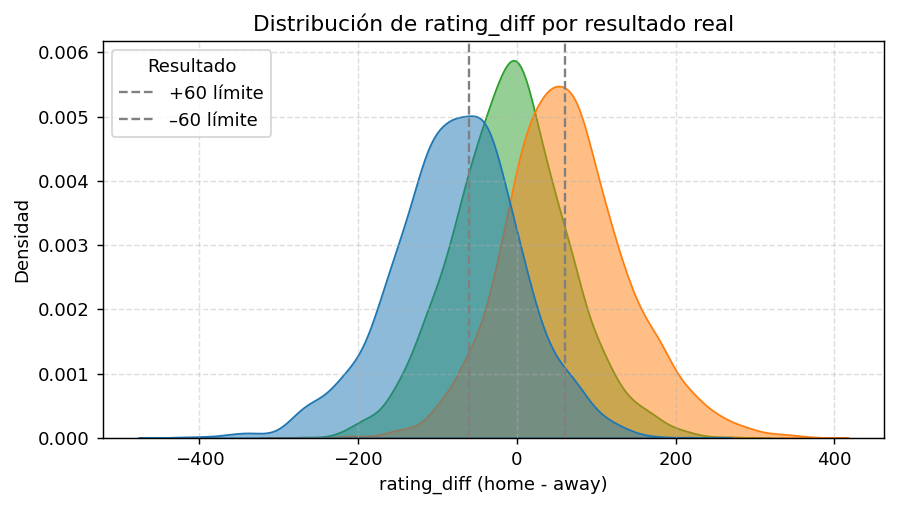

+60 límite → gray
–60 límite → gray


In [23]:
# OM: Visualización de rating_diff para ver el “corte” de partidos parejos
# Dataset de prueba: rating_diff + resultado real
df_plot = pd.DataFrame({
    "rating_diff": Xp_te["rating_diff"],
    "resultado": y_te
})

plt.figure(figsize=(7,4))
ax = sns.kdeplot(
    data=df_plot,
    x="rating_diff",
    hue="resultado",
    fill=True,
    common_norm=False,
    alpha=0.5
)

# === Líneas de corte ===
plt.axvline(60, color="gray", linestyle="--", linewidth=1.3, label="+60 límite")
plt.axvline(-60, color="gray", linestyle="--", linewidth=1.3, label="–60 límite")

plt.title("Distribución de rating_diff por resultado real")
plt.xlabel("rating_diff (home - away)")
plt.ylabel("Densidad")
plt.legend(title="Resultado", loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# (opcional) Mostrar mapeo de colores en consola
legend = ax.legend_
for txt, line in zip(legend.get_texts(), legend.get_lines()):
    print(f"{txt.get_text():<5} → {line.get_color()}")


=== BINARIO (win vs no-win) @thr=0.50 ===
Accuracy : 0.760
Precision: 0.751
Recall   : 0.761
F1       : 0.756
ROC-AUC  : 0.839


<Figure size 585x520 with 0 Axes>

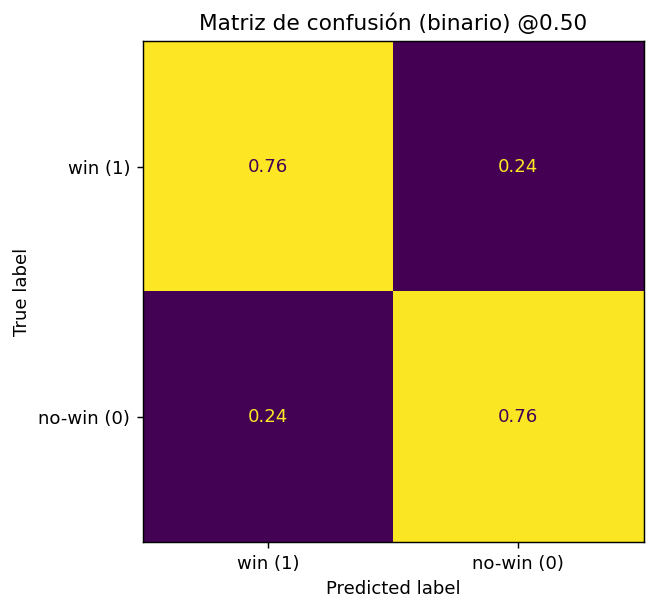


=== Mejor umbral por F1 ===
thr          0.400
accuracy     0.750
precision    0.703
recall       0.847
f1           0.768
Name: 10, dtype: float64


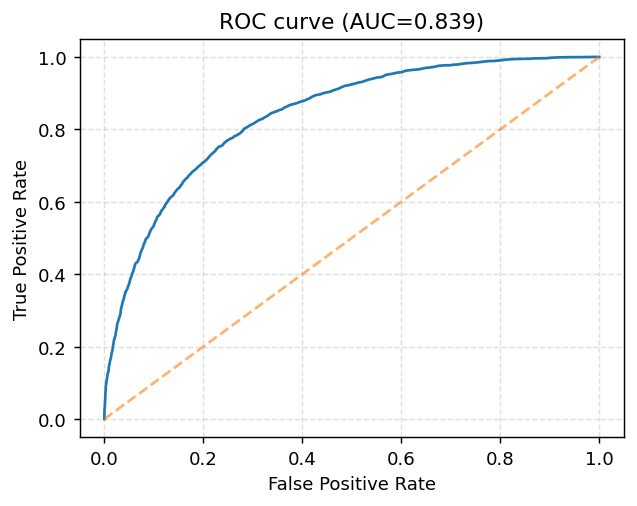

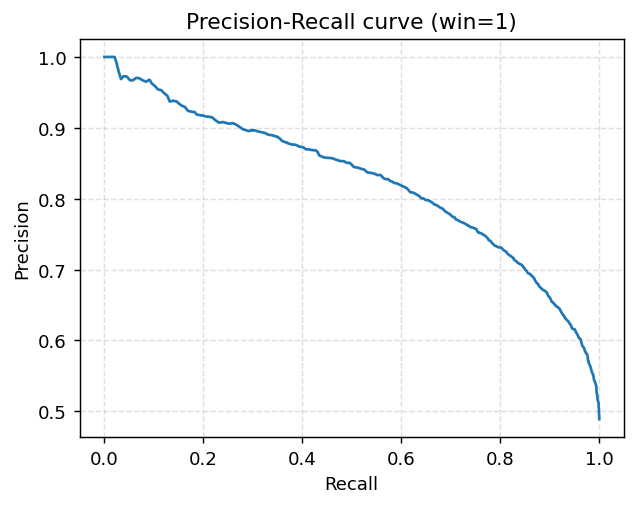


=== BINARIO @thr=0.40 (óptimo por F1) ===
Accuracy : 0.750
Precision: 0.703
Recall   : 0.847
F1       : 0.768


In [24]:
# OM: Modelo BINARIO: win (1) vs no-win (0: draw o loss)
# ============================================

# --- 1) Target binario
df_bin = results_with_rating.copy()  # contiene rating_diff
df_bin["target_bin"] = (df_bin["target"] == "win").astype(int)  # win=1, no-win=0
thr_bin = 0.40   # binario

# --- 2) Features
feat_cat = ["home_team", "away_team", "tournament"]
feat_num = ["neutral", "year", "month", "dayofweek", "rating_diff"]
X = df_bin[feat_cat + feat_num]
y = df_bin["target_bin"]

# --- 3) Split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- 4) Preprocesamiento + Modelo
pre = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    verbose_feature_names_out=False,
    remainder="drop"
)

clf_bin = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"  # compensa si la tasa de win != 0.5
    ))
])

# --- 5) Entrenar
clf_bin.fit(X_tr, y_tr)

# --- 6) Predicción base (umbral 0.5) y probabilidades
p_win = clf_bin.predict_proba(X_te)[:, 1]  # prob de win
y_pred05 = (p_win >= 0.5).astype(int)

# --- 7) Métricas @0.5
acc = accuracy_score(y_te, y_pred05)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred05, average="binary", zero_division=0)
auc = roc_auc_score(y_te, p_win)

print("=== BINARIO (win vs no-win) @thr=0.50 ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1       : {f1:.3f}")
print(f"ROC-AUC  : {auc:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_te, y_pred05, labels=[1,0], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["win (1)","no-win (0)"])
plt.figure(figsize=(4.5,4))
disp.plot(values_format=".2f", colorbar=False)
plt.title("Matriz de confusión (binario) @0.50")
plt.show()

# --- 8) Buscar mejor umbral por F1
ths = np.linspace(0.3, 0.7, 41)  # barrido fino
rows = []
for t in ths:
    y_hat = (p_win >= t).astype(int)
    acc_t = accuracy_score(y_te, y_hat)
    prec_t, rec_t, f1_t, _ = precision_recall_fscore_support(y_te, y_hat, average="binary", zero_division=0)
    rows.append({"thr": t, "accuracy": acc_t, "precision": prec_t, "recall": rec_t, "f1": f1_t})
scan = pd.DataFrame(rows)
best = scan.sort_values("f1", ascending=False).iloc[0]
print("\n=== Mejor umbral por F1 ===")
print(best.round(3))

# Curvas ROC y PR
fpr, tpr, _ = roc_curve(y_te, p_win)
pr, rc, _ = precision_recall_curve(y_te, p_win)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={auc:.3f})")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

plt.figure(figsize=(5,4))
plt.plot(rc, pr)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (win=1)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

# --- 9) Predicción con umbral óptimo (opcional)
y_pred_opt = (p_win >= thr_bin).astype(int)
acc_o = accuracy_score(y_te, y_pred_opt)
prec_o, rec_o, f1_o, _ = precision_recall_fscore_support(y_te, y_pred_opt, average="binary", zero_division=0)
print(f"\n=== BINARIO @thr={thr_bin:.2f} (óptimo por F1) ===")
print(f"Accuracy : {acc_o:.3f}")
print(f"Precision: {prec_o:.3f}")
print(f"Recall   : {rec_o:.3f}")
print(f"F1       : {f1_o:.3f}")


In [25]:
# OM: Comparación de varios modelos en binario win vs no-win
# ===========================================================

try:
    from lightgbm import LGBMClassifier
except:
    LGBMClassifier = None
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None

# --- Dataset binario (usamos results_with_rating que ya generaste)
df = results_with_rating.copy()
df["target_bin"] = (df["target"] == "win").astype(int)
feat_cat = ["home_team","away_team","tournament"]
feat_num = ["neutral","year","month","dayofweek","rating_diff"]
X = df[feat_cat + feat_num]
y = df["target_bin"]

# Split fijo para comparar manzanas con manzanas
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Preprocesamiento común
pre = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    verbose_feature_names_out=False,
    remainder="drop"
)

def eval_model(name, clf):
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else pipe.decision_function(X_te)
    y_hat = (p >= 0.5).astype(int)
    acc = accuracy_score(y_te, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_hat, average="binary", zero_division=0)
    auc = roc_auc_score(y_te, p)
    print(f"\n[{name}]  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")
    return {"name":name, "acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

results = []

# 1) RandomForest (baseline que ya tenías)
rf = RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1,
                            class_weight="balanced", random_state=42)
results.append(eval_model("RandomForest", rf))

# 2) HistGradientBoosting (no requiere libs externas)
hgb = HistGradientBoostingClassifier(
    max_depth=None, learning_rate=0.15, max_bins=255, l2_regularization=1.0,
    early_stopping=True, random_state=42
)
results.append(eval_model("HistGradientBoosting", hgb))

# 3) LightGBM (si está disponible)
if LGBMClassifier is not None:
    lgbm = LGBMClassifier(
        n_estimators=800, learning_rate=0.05, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, class_weight="balanced", random_state=42,
        n_jobs=-1
    )
    results.append(eval_model("LightGBM", lgbm))
else:
    print("\n[LightGBM] No instalado (pip install lightgbm)")

# 4) XGBoost (si está disponible)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", n_jobs=-1, random_state=42
    )
    results.append(eval_model("XGBoost", xgb))
else:
    print("\n[XGBoost] No instalado (pip install xgboost)")

# 5) Logistic Regression (baseline lineal y calibrable)
logit = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
results.append(eval_model("LogisticRegression", logit))

# Resumen ordenado por AUC y F1
res_df = pd.DataFrame(results).sort_values(["auc","f1","acc"], ascending=False)
print("\n=== Ranking modelos (ordenado por AUC, luego F1) ===")
print(res_df.round(3))


[RandomForest]  Acc=0.760  Prec=0.752  Rec=0.760  F1=0.756  AUC=0.840

[HistGradientBoosting]  Acc=0.766  Prec=0.758  Rec=0.766  F1=0.762  AUC=0.848
[LightGBM] [Info] Number of positive: 18413, number of negative: 19228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 37641, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

[LightGBM]  Acc=0.765  Prec=0.753  Rec=0.773  F1=0.763  AUC=0.845

[XGBoost]  Acc=0.766  Prec=0.757  Rec=0.769  F1=0.763  AUC=0.848

[LogisticRegression]  Acc=0.765  Prec=0.755  Rec=0.769  F1=0.762  AUC=0.843

=== Ranking modelos (ordenado por AUC, luego F1) ===
                   name    acc

In [35]:
# OM: ELO dinámico: 3 años de half-life + ventana 40 partidos / 3 años
# Filtro: desde 1930 y sin "Friendly"
# ============================================
# --- 0) Partimos del dataset original 'results' y filtramos
results_v2 = pd.read_csv("./archive/results.csv", parse_dates=["date"])
results_v2["date"] = pd.to_datetime(results_v2["date"], format="mixed", dayfirst=True, errors="coerce")

df0 = results_v2.copy()
df0["date"] = pd.to_datetime(df0["date"])
df0 = df0[df0["date"].dt.year >= 1930].copy()
df0 = df0[df0["tournament"] != "Friendly"].copy()
df0 = df0.sort_values("date").reset_index(drop=True)

# --- 1) Parámetros del ELO
R0 = 1500.0
K_base = 20.0
HOME_ADV = 80.0            # ventaja local clásica
half_life_years = 0.5      # años de half-life para el ELO dinámico
half_life_days  = 365.0 * half_life_years
N_prev = 10                # tope de partidos por equipo
WINDOW_DAYS = 365 * half_life_years      # ventana temporal dura (años)

# pesos por torneo (default 1.1 para no listados)
weights = {
    "FIFA World Cup": 1.6,
    "UEFA European Championship": 1.4,
    "Copa América": 1.4,
    "FIFA World Cup qualification": 1.3,
    "UEFA Nations League": 1.2,
    # "Friendly": 0.9,  # no hace falta, ya fue filtrado
}
def w_tournament(t):
    return weights.get(t, 1.1)

def elo_expect(Ra, Rb, home_adv):
    return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

# --- 2) Estructuras de estado
ratings = {}                  # rating actual por selección
last_played = {}              # última fecha jugada
recent_dates = {}             # deque de fechas recientes por team (cap N_prev)
snapshots = []

# --- 3) Para consulta rápida de historial en ventana temporal
# guardaremos también las listas de fechas completas (no solo el deque capado)
history_dates = {}

teams_all = pd.concat([df0["home_team"], df0["away_team"]]).unique()
for t in teams_all:
    ratings[t] = R0
    recent_dates[t] = deque(maxlen=N_prev)
    history_dates[t] = []  # todas las fechas (para filtrar por 3 años)

# --- 4) Loop por partidos cronológicos
for _, row in df0.iterrows():
    d   = row["date"]
    ht  = row["home_team"]; at  = row["away_team"]
    hs  = row["home_score"]; as_ = row["away_score"]
    tour = row["tournament"]; neut = bool(row["neutral"])

    # --- Decaimiento temporal hacia R0 (si pasó tiempo desde su último partido)
    for team in (ht, at):
        if team in last_played:
            delta_days = (d - last_played[team]).days
            if delta_days > 0:
                decay = 0.5 ** (delta_days / half_life_days)
                ratings[team] = R0 + (ratings[team] - R0) * decay

    Rh, Ra = ratings[ht], ratings[at]

    # --- Probabilidad esperada con ventaja local (si no es neutral)
    home_adv = 0.0 if neut else HOME_ADV
    Eh = elo_expect(Rh, Ra, home_adv)
    Ea = 1.0 - Eh

    # --- Resultado real (POV local)
    if   hs > as_: Sh, Sa = 1.0, 0.0
    elif hs < as_: Sh, Sa = 0.0, 1.0
    else:          Sh, Sa = 0.5, 0.5

    # --- Margen de victoria suavizado
    margin = max(1.0, log(1 + abs(hs - as_), 2))

    # --- K dinámico por torneo + margen
    Kw_base = K_base * w_tournament(tour) * margin

    # --- Evidencia disponible por equipo:
    # (a) por cantidad de partidos (deque, cap N_prev)
    cnt_h = len(recent_dates[ht])
    cnt_a = len(recent_dates[at])

    # (b) por ventana temporal (últimos 3 años)
    # filtramos cuántos partidos del team caen en [d - WINDOW_DAYS, d)
    cutoff = d - pd.Timedelta(days=WINDOW_DAYS)
    hist_h = [x for x in history_dates[ht] if x >= cutoff]
    hist_a = [x for x in history_dates[at] if x >= cutoff]
    cnt_h_time = len(hist_h)
    cnt_a_time = len(hist_a)

    # factor de evidencia = fracción de "completo" por ambos criterios
    frac_h = min(1.0, cnt_h / N_prev) * (0.5 + 0.5 * min(1.0, cnt_h_time / N_prev))
    frac_a = min(1.0, cnt_a / N_prev) * (0.5 + 0.5 * min(1.0, cnt_a_time / N_prev))
    # nunca cero: mínimo 0.5x para que igual aprenda si hay poquita historia
    Kw_h = Kw_base * max(0.5, frac_h)
    Kw_a = Kw_base * max(0.5, frac_a)

    # --- Actualización de ratings
    ratings[ht] = Rh + Kw_h * (Sh - Eh)
    ratings[at] = Ra + Kw_a * (Sa - Ea)

    # --- Actualizamos contadores y memoria
    recent_dates[ht].append(d);  recent_dates[at].append(d)
    history_dates[ht].append(d); history_dates[at].append(d)
    last_played[ht] = d;         last_played[at] = d

    # --- Snapshot (post-actualización) para el merge posterior
    snapshots.append({
        "date": d,
        "home_team": ht, "away_team": at,
        "home_rating": ratings[ht],
        "away_rating": ratings[at]
    })

ratings_df = pd.DataFrame(snapshots).sort_values("date").reset_index(drop=True)

# --- 5) Merge al dataset y feature final
results_with_rating_v2 = df0.merge(
    ratings_df, on=["date","home_team","away_team"], how="left"
)
results_with_rating_v2["rating_diff"] = (
    results_with_rating_v2["home_rating"] - results_with_rating_v2["away_rating"]
)

# --- 6) Variables temporales
for col in ["year","month","dayofweek"]:
    if col not in results_with_rating_v2.columns:
        results_with_rating_v2["year"] = results_with_rating_v2["date"].dt.year
        results_with_rating_v2["month"] = results_with_rating_v2["date"].dt.month
        results_with_rating_v2["dayofweek"] = results_with_rating_v2["date"].dt.dayofweek
        break

# --- 7) Target
if "target" not in results_with_rating_v2.columns:
    gd = results_with_rating_v2["home_score"] - results_with_rating_v2["away_score"]
    results_with_rating_v2["target"] = np.select(
        [gd > 0, gd == 0, gd < 0],
        ["win","draw","loss"],
        default="draw"
    )

print("✅ ELO v2 listo (3y, 40 partidos, sin Friendly).")
print(results_with_rating_v2[["date","home_team","away_team","tournament","rating_diff"]].tail(5))

✅ ELO v2 listo (3y, 40 partidos, sin Friendly).
            date    home_team  away_team                    tournament  \
29795 2025-09-09         Peru   Paraguay  FIFA World Cup qualification   
29796 2025-09-09      Ecuador  Argentina  FIFA World Cup qualification   
29797 2025-09-09  New Zealand  Australia                  Soccer Ashes   
29798 2025-09-09        Benin    Lesotho  FIFA World Cup qualification   
29799 2025-09-09       Serbia    England  FIFA World Cup qualification   

       rating_diff  
29795   -53.265411  
29796   -12.543026  
29797   -44.055758  
29798    61.709461  
29799   -83.592678  


In [36]:
# OM: Comparación de varios modelos en binario win vs no-win con rating_diff mejorado
# === Extensión: ELO dinámico (3 años, 40 partidos, sin Friendly) 
# ===========================================================

try:
    from lightgbm import LGBMClassifier
except:
    LGBMClassifier = None
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None

# --- Dataset binario (usamos results_with_rating que ya generaste)
df = results_with_rating_v2.copy()
df["target_bin"] = (df["target"] == "win").astype(int)
feat_cat = ["home_team","away_team","tournament"]
feat_num = ["neutral","year","month","dayofweek","rating_diff"]
X = df[feat_cat + feat_num]
y = df["target_bin"]

# Split fijo para comparar manzanas con manzanas
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Preprocesamiento común
pre = ColumnTransformer(
    transformers=[
        ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
        ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
        ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
        ("num", "passthrough", feat_num),
    ],
    verbose_feature_names_out=False,
    remainder="drop"
)

def eval_model(name, clf):
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_tr, y_tr)
    p = pipe.predict_proba(X_te)[:,1] if hasattr(pipe.named_steps["clf"], "predict_proba") else pipe.decision_function(X_te)
    y_hat = (p >= 0.5).astype(int)
    acc = accuracy_score(y_te, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_hat, average="binary", zero_division=0)
    auc = roc_auc_score(y_te, p)
    print(f"\n[{name}]  Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}")
    return {"name":name, "acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

results = []

# 1) RandomForest (baseline que ya tenías)
rf = RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=-1,
                            class_weight="balanced", random_state=42)
results.append(eval_model("RandomForest", rf))

# 2) HistGradientBoosting (no requiere libs externas)
hgb = HistGradientBoostingClassifier(
    max_depth=None, learning_rate=0.15, max_bins=255, l2_regularization=1.0,
    early_stopping=True, random_state=42
)
results.append(eval_model("HistGradientBoosting", hgb))

# 3) LightGBM (si está disponible)
if LGBMClassifier is not None:
    lgbm = LGBMClassifier(
        n_estimators=800, learning_rate=0.05, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, class_weight="balanced", random_state=42,
        n_jobs=-1
    )
    results.append(eval_model("LightGBM", lgbm))
else:
    print("\n[LightGBM] No instalado (pip install lightgbm)")

# 4) XGBoost (si está disponible)
if XGBClassifier is not None:
    xgb = XGBClassifier(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", n_jobs=-1, random_state=42
    )
    results.append(eval_model("XGBoost", xgb))
else:
    print("\n[XGBoost] No instalado (pip install xgboost)")

# 5) Logistic Regression (baseline lineal y calibrable)
logit = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
results.append(eval_model("LogisticRegression", logit))

# Resumen ordenado por AUC y F1
res_df = pd.DataFrame(results).sort_values(["auc","f1","acc"], ascending=False)
print("\n=== Ranking modelos (ordenado por AUC, luego F1) ===")
print(res_df.round(3))


[RandomForest]  Acc=0.836  Prec=0.830  Rec=0.846  F1=0.838  AUC=0.909

[HistGradientBoosting]  Acc=0.840  Prec=0.835  Rec=0.847  F1=0.841  AUC=0.912
[LightGBM] [Info] Number of positive: 11905, number of negative: 11935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 23840, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

[LightGBM]  Acc=0.834  Prec=0.828  Rec=0.844  F1=0.836  AUC=0.909

[XGBoost]  Acc=0.835  Prec=0.826  Rec=0.849  F1=0.837  AUC=0.909

[LogisticRegression]  Acc=0.841  Prec=0.834  Rec=0.851  F1=0.842  AUC=0.909

=== Ranking modelos (ordenado por AUC, luego F1) ===
                   name    acc   prec    rec     f1    auc
1  HistGradientBoosting  0.840  0.8

=== Resultados por configuración (orden AUC) ===


,label,half_life_years,N_prev,auc,f1,acc,prec,rec
0,0.5y/10p,0.5,10,0.912,0.841,0.840,0.835,0.847
1,1y/20p,1.0,20,0.887,0.811,0.809,0.802,0.820
2,2y/30p,2.0,30,0.864,0.786,0.784,0.779,0.793
3,3y/40p,3.0,40,0.855,0.782,0.779,0.771,0.793
4,5y/40p,5.0,40,0.849,0.775,0.773,0.765,0.786
5,5y/60p,5.0,60,0.844,0.769,0.766,0.757,0.782


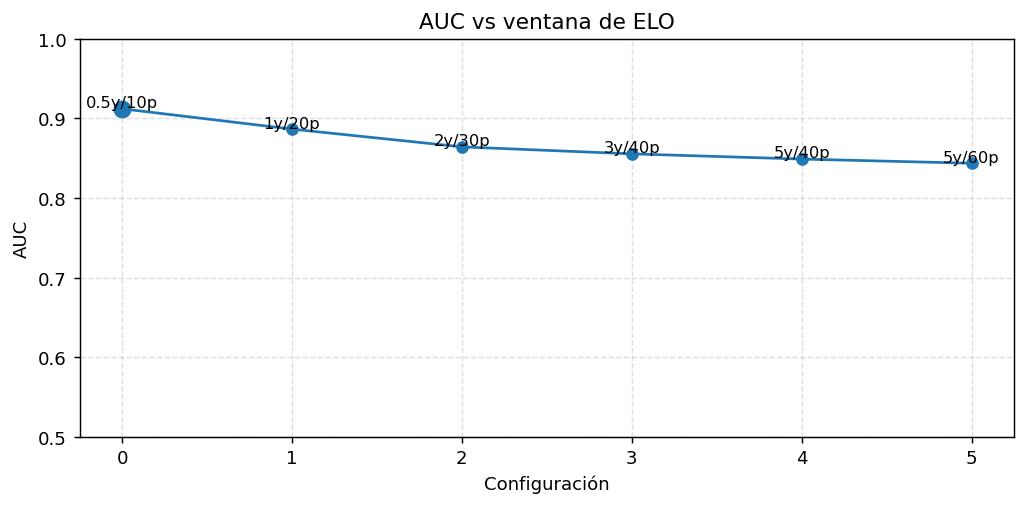

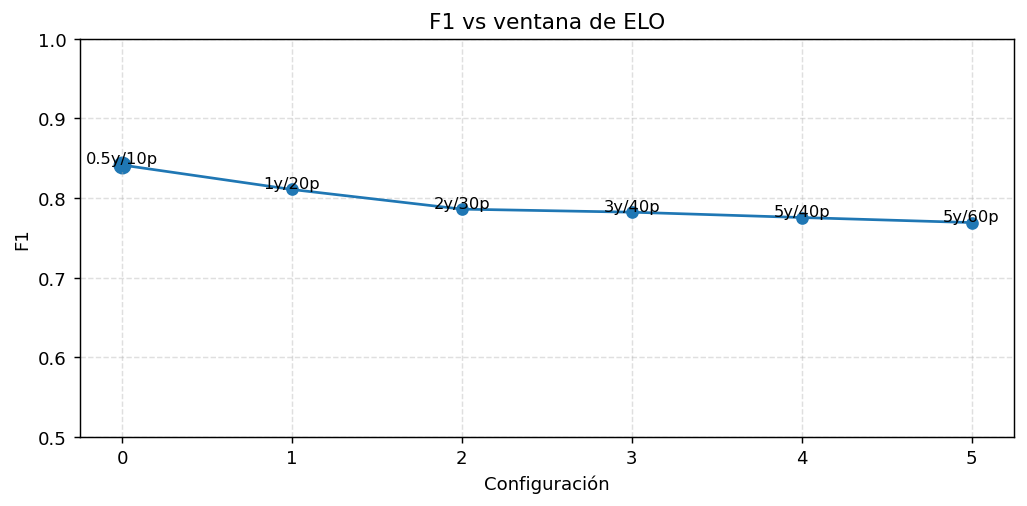

In [38]:
# OM: Comparativas grafficas de ratios con distintos cálculos de ELO
results = pd.read_csv("./archive/results.csv", parse_dates=["date"])
results["date"] = pd.to_datetime(results["date"], format="mixed", dayfirst=True, errors="coerce")
df0["date"] = pd.to_datetime(df0["date"])

# ---------- 1) Función para construir dataset con ELO ----------
def build_elo_dataset(
    df_raw: pd.DataFrame,
    *,
    min_year=1930,
    exclude_friendly=True,
    half_life_years=0.5,
    N_prev=10,
    window_years=1,
    R0=1500.0,
    K_base=20.0,
    HOME_ADV=80.0
) -> pd.DataFrame:
    df0 = df_raw.copy()
    df0["date"] = pd.to_datetime(df0["date"])
    df0 = df0[df0["date"].dt.year >= min_year]
    if exclude_friendly:
        df0 = df0[df0["tournament"] != "Friendly"]
    df0 = df0.sort_values("date").reset_index(drop=True)

    weights = {
        "FIFA World Cup": 1.6,
        "UEFA European Championship": 1.4,
        "Copa América": 1.4,
        "FIFA World Cup qualification": 1.3,
        "UEFA Nations League": 1.2,
    }
    def w_tournament(t): return weights.get(t, 1.1)

    def elo_expect(Ra, Rb, home_adv):
        return 1.0 / (1.0 + 10.0 ** ((Rb - (Ra + home_adv)) / 400.0))

    half_life_days = 365.0 * half_life_years
    window_days = 365 * window_years if window_years is not None else 10_000

    ratings = {}
    last_played = {}
    recent_dates = {}
    history_dates = {}
    snapshots = []

    teams_all = pd.concat([df0["home_team"], df0["away_team"]]).unique()
    for t in teams_all:
        ratings[t] = R0
        recent_dates[t] = deque(maxlen=N_prev)
        history_dates[t] = []

    for _, row in df0.iterrows():
        d   = row["date"]
        ht  = row["home_team"]; at  = row["away_team"]
        hs  = row["home_score"]; as_ = row["away_score"]
        tour = row["tournament"]; neut = bool(row["neutral"])

        # decaimiento temporal
        for team in (ht, at):
            if team in last_played:
                delta_days = (d - last_played[team]).days
                if delta_days > 0:
                    decay = 0.5 ** (delta_days / half_life_days)
                    ratings[team] = R0 + (ratings[team] - R0) * decay

        Rh, Ra = ratings[ht], ratings[at]
        home_adv = 0.0 if neut else HOME_ADV
        Eh = elo_expect(Rh, Ra, home_adv)
        Ea = 1.0 - Eh

        if   hs > as_: Sh, Sa = 1.0, 0.0
        elif hs < as_: Sh, Sa = 0.0, 1.0
        else:          Sh, Sa = 0.5, 0.5

        margin = max(1.0, log(1 + abs(hs - as_), 2))
        Kw_base = K_base * w_tournament(tour) * margin

        cutoff = d - pd.Timedelta(days=window_days)
        cnt_h_time = sum(x >= cutoff for x in history_dates[ht])
        cnt_a_time = sum(x >= cutoff for x in history_dates[at])

        cnt_h = len(recent_dates[ht])
        cnt_a = len(recent_dates[at])

        frac_h = min(1.0, cnt_h / N_prev) * (0.5 + 0.5 * min(1.0, cnt_h_time / N_prev))
        frac_a = min(1.0, cnt_a / N_prev) * (0.5 + 0.5 * min(1.0, cnt_a_time / N_prev))

        Kw_h = Kw_base * max(0.5, frac_h)
        Kw_a = Kw_base * max(0.5, frac_a)

        ratings[ht] = Rh + Kw_h * (Sh - Eh)
        ratings[at] = Ra + Kw_a * (Sa - Ea)

        recent_dates[ht].append(d);  recent_dates[at].append(d)
        history_dates[ht].append(d); history_dates[at].append(d)
        last_played[ht] = d;         last_played[at] = d

        snapshots.append({
            "date": d,
            "home_team": ht, "away_team": at,
            "home_rating": ratings[ht],
            "away_rating": ratings[at]
        })

    ratings_df = pd.DataFrame(snapshots).sort_values("date").reset_index(drop=True)
    out = df0.merge(ratings_df, on=["date","home_team","away_team"], how="left")
    out["rating_diff"] = out["home_rating"] - out["away_rating"]

    # features temporales (si no existen)
    if "year" not in out.columns:
        out["year"] = out["date"].dt.year
        out["month"] = out["date"].dt.month
        out["dayofweek"] = out["date"].dt.dayofweek

    # target si falta
    if "target" not in out.columns:
        gd = out["home_score"] - out["away_score"]
        out["target"] = np.select([gd>0, gd==0, gd<0], ["win","draw","loss"], default="draw")

    return out

# ---------- 2) Evaluación binaria (win vs no-win) ----------
def eval_binario(df_with_rating) -> dict:
    df = df_with_rating.copy()
    df["target_bin"] = (df["target"] == "win").astype(int)

    feat_cat = ["home_team","away_team","tournament"]
    feat_num = ["neutral","year","month","dayofweek","rating_diff"]

    X = df[feat_cat + feat_num]
    y = df["target_bin"]

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    pre = ColumnTransformer(
        transformers=[
            ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
            ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
            ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
            ("num", "passthrough", feat_num),
        ],
        verbose_feature_names_out=False,
        remainder="drop"
    )

    clf = HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.15, max_bins=255,
        l2_regularization=1.0, early_stopping=True, random_state=42
    )

    pipe = Pipeline([("pre", pre), ("clf", clf)])
    pipe.fit(X_tr, y_tr)

    p = pipe.predict_proba(X_te)[:,1]
    yhat = (p >= 0.5).astype(int)

    acc = accuracy_score(y_te, yhat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_te, yhat, average="binary", zero_division=0)
    auc = roc_auc_score(y_te, p)

    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}

# ---------- 3) Grid de configuraciones a testear ----------
# (podés sumar/quitar fácilmente)
configs = [
    {"label":"0.5y/10p", "half_life_years":0.5, "N_prev":10, "window_years":0.5},
    {"label":"1y/20p",   "half_life_years":1.0, "N_prev":20, "window_years":1.0},
    {"label":"2y/30p",   "half_life_years":2.0, "N_prev":30, "window_years":2.0},
    {"label":"3y/40p",   "half_life_years":3.0, "N_prev":40, "window_years":3.0},
    {"label":"5y/40p",   "half_life_years":5.0, "N_prev":40, "window_years":5.0},
    {"label":"5y/60p",   "half_life_years":5.0, "N_prev":60, "window_years":5.0},
]

# ---------- 4) Ejecutar, recolectar métricas y graficar ----------
rows = []
for cfg in configs:
    ds = build_elo_dataset(
        results,
        min_year=1930,
        exclude_friendly=True,
        half_life_years=cfg["half_life_years"],
        N_prev=cfg["N_prev"],
        window_years=cfg["window_years"]
    )
    met = eval_binario(ds)
    rows.append({**cfg, **met})

perf = pd.DataFrame(rows)
perf = perf[["label","half_life_years","N_prev","auc","f1","acc","prec","rec"]].sort_values("auc", ascending=False)
print("=== Resultados por configuración (orden AUC) ===")
display(perf.round(3))

# --- Plot AUC ---
plt.figure(figsize=(8,4))
x = np.arange(len(perf))
plt.plot(x, perf["auc"].values, marker="o")
best_idx = int(np.argmax(perf["auc"].values))
plt.scatter([best_idx], [perf["auc"].iloc[best_idx]], s=80)
for i, lbl in enumerate(perf["label"]):
    plt.text(i, perf["auc"].values[i]+0.002, lbl, ha="center", fontsize=9, rotation=0)
plt.title("AUC vs ventana de ELO")
plt.ylabel("AUC")
plt.xlabel("Configuración")
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Plot F1 ---
plt.figure(figsize=(8,4))
plt.plot(x, perf["f1"].values, marker="o")
best_idx_f1 = int(np.argmax(perf["f1"].values))
plt.scatter([best_idx_f1], [perf["f1"].iloc[best_idx_f1]], s=80)
for i, lbl in enumerate(perf["label"]):
    plt.text(i, perf["f1"].values[i]+0.002, lbl, ha="center", fontsize=9, rotation=0)
plt.title("F1 vs ventana de ELO")
plt.ylabel("F1")
plt.xlabel("Configuración")
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 11905, number of negative: 11935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 23840, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 11905, number of negative: 11935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 23840, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info

model,HistGradientBoosting,LightGBM,LogisticRegression,RandomForest,XGBoost
label,,,,,
0.5y/10p,0.912,0.909,0.909,0.909,0.909
1y/20p,0.887,0.881,0.881,0.881,0.883
2y/30p,0.864,0.858,0.860,0.857,0.861
3y/40p,0.855,0.849,0.850,0.849,0.851
5y/40p,0.849,0.843,0.845,0.842,0.844
5y/60p,0.844,0.839,0.841,0.837,0.841



=== F1 por config y modelo ===


model,HistGradientBoosting,LightGBM,LogisticRegression,RandomForest,XGBoost
label,,,,,
0.5y/10p,0.841,0.836,0.842,0.838,0.837
1y/20p,0.811,0.801,0.809,0.807,0.809
2y/30p,0.786,0.777,0.782,0.779,0.782
3y/40p,0.782,0.771,0.775,0.776,0.772
5y/40p,0.775,0.763,0.769,0.768,0.769
5y/60p,0.769,0.762,0.766,0.763,0.764


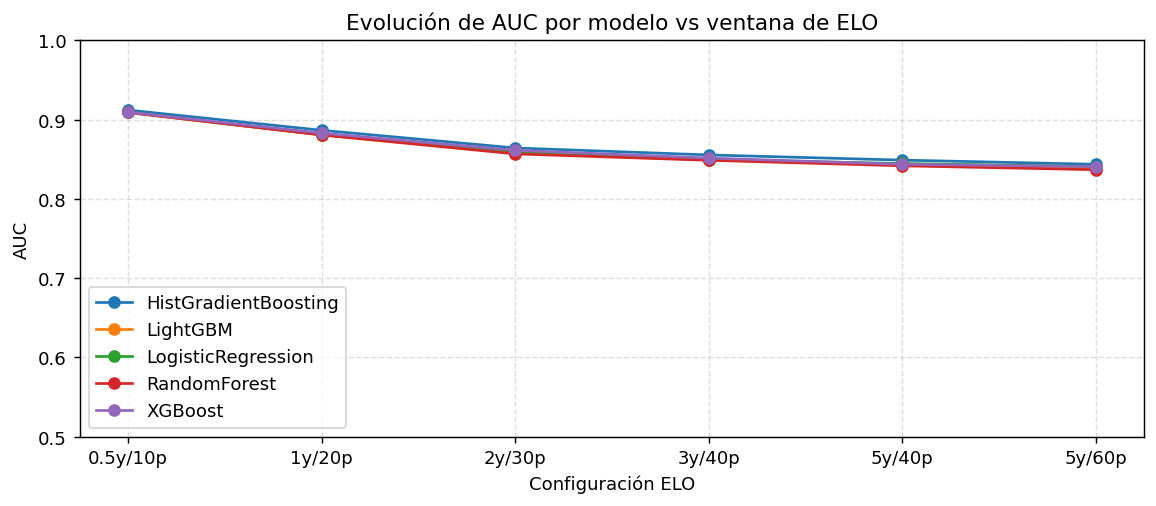

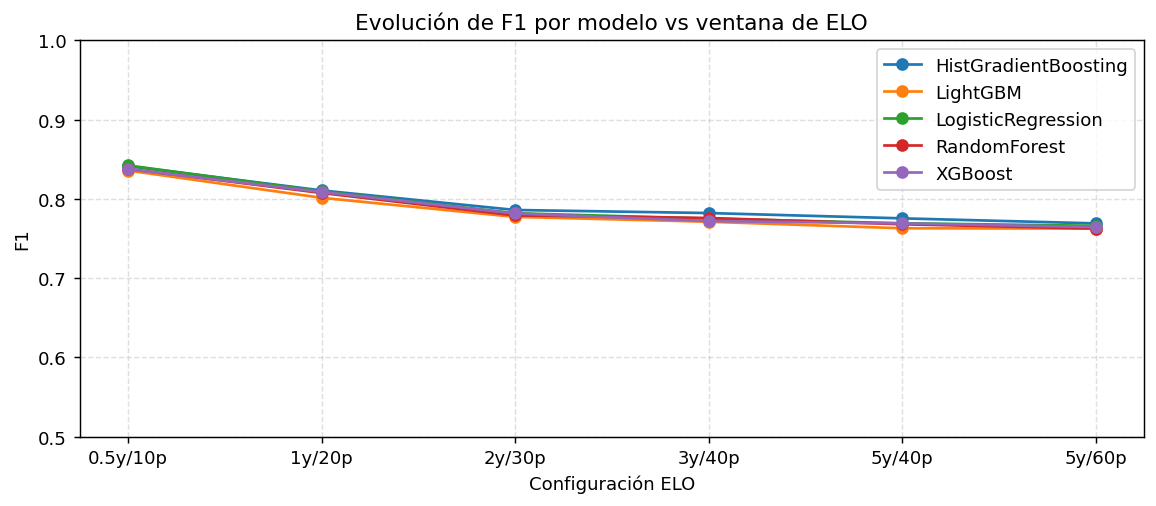

In [39]:
# OM: Gráfica de evolución unificada
# Evolución por modelo (5 líneas) vs configuración de ELO
# Métricas: AUC y F1
# =========================================================

# Modelos extra si están instalados
try:
    from lightgbm import LGBMClassifier
except:
    LGBMClassifier = None
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None

# ---------- Configs de ELO a comparar (en tu orden preferido) ----------
elo_configs = [
    {"label":"0.5y/10p", "half_life_years":0.5, "N_prev":10, "window_years":0.5},
    {"label":"1y/20p",   "half_life_years":1.0, "N_prev":20, "window_years":1.0},
    {"label":"2y/30p",   "half_life_years":2.0, "N_prev":30, "window_years":2.0},
    {"label":"3y/40p",   "half_life_years":3.0, "N_prev":40, "window_years":3.0},
    {"label":"5y/40p",   "half_life_years":5.0, "N_prev":40, "window_years":5.0},
    {"label":"5y/60p",   "half_life_years":5.0, "N_prev":60, "window_years":5.0},
]

# ---------- Modelos a evaluar (5 líneas) ----------
models = {
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.15, max_bins=255,
        l2_regularization=1.0, early_stopping=True, random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=800, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss",
        n_jobs=-1, random_state=42
    ) if XGBClassifier is not None else None,
    "LightGBM": LGBMClassifier(
        n_estimators=800, learning_rate=0.05, num_leaves=63,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        class_weight="balanced", random_state=42, n_jobs=-1
    ) if LGBMClassifier is not None else None,
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=400, n_jobs=-1, class_weight="balanced", random_state=42),
}
# filtrar los que no están disponibles
models = {k:v for k,v in models.items() if v is not None}

# ---------- Evaluación por config y por modelo ----------
rows = []
for cfg in elo_configs:
    # Construir dataset de ELO (usa tu función ya definida)
    ds = build_elo_dataset(
        results,
        min_year=1930,
        exclude_friendly=True,
        half_life_years=cfg["half_life_years"],
        N_prev=cfg["N_prev"],
        window_years=cfg["window_years"]
    )

    # Target binario y features
    df = ds.copy()
    df["target_bin"] = (df["target"] == "win").astype(int)
    feat_cat = ["home_team","away_team","tournament"]
    feat_num = ["neutral","year","month","dayofweek","rating_diff"]
    X = df[feat_cat + feat_num]; y = df["target_bin"]

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    pre = ColumnTransformer(
        transformers=[
            ("home_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["home_team"]),
            ("away_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["away_team"]),
            ("tour_te", ce.TargetEncoder(handle_missing="value", handle_unknown="value"), ["tournament"]),
            ("num", "passthrough", feat_num),
        ],
        verbose_feature_names_out=False,
        remainder="drop"
    )

    for name, clf in models.items():
        pipe = Pipeline([("pre", pre), ("clf", clf)])
        pipe.fit(X_tr, y_tr)
        # proba o decision_function
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            p = pipe.predict_proba(X_te)[:,1]
        else:
            # decision_function puede devolver reales sin [0,1]; sirve igual para AUC
            p = pipe.decision_function(X_te)
        yhat = (p >= 0.5).astype(int)

        acc = accuracy_score(y_te, yhat)
        prec, rec, f1, _ = precision_recall_fscore_support(y_te, yhat, average="binary", zero_division=0)
        auc = roc_auc_score(y_te, p)
        rows.append({
            "label": cfg["label"],
            "half_life_years": cfg["half_life_years"],
            "N_prev": cfg["N_prev"],
            "model": name,
            "acc": acc, "f1": f1, "auc": auc, "prec": prec, "rec": rec
        })

perf = pd.DataFrame(rows)

# ---------- Tabla resumen “pipí-cucú” ----------
pivot_auc = perf.pivot(index="label", columns="model", values="auc").reindex([c["label"] for c in elo_configs])
pivot_f1  = perf.pivot(index="label", columns="model", values="f1").reindex([c["label"] for c in elo_configs])

print("=== AUC por config y modelo ===")
display(pivot_auc.round(3))
print("\n=== F1 por config y modelo ===")
display(pivot_f1.round(3))

# ---------- Plots (5 líneas): AUC y F1 ----------
x = np.arange(len(pivot_auc.index))  # posiciones

plt.figure(figsize=(9,4))
for m in pivot_auc.columns:
    plt.plot(x, pivot_auc[m].values, marker="o", label=m)
plt.xticks(x, pivot_auc.index, rotation=0)
plt.ylim(0.5, 1.0)
plt.xlabel("Configuración ELO")
plt.ylabel("AUC")
plt.title("Evolución de AUC por modelo vs ventana de ELO")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
for m in pivot_f1.columns:
    plt.plot(x, pivot_f1[m].values, marker="o", label=m)
plt.xticks(x, pivot_f1.index, rotation=0)
plt.ylim(0.5, 1.0)
plt.xlabel("Configuración ELO")
plt.ylabel("F1")
plt.title("Evolución de F1 por modelo vs ventana de ELO")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


#Fin modelo propuesto por OM